# ODE/FBA BioSimulators Composite

In [1]:
# change working directory to the vivarium-biosimulators
import sys, os
notebook_path = sys.path[0][:sys.path[0].index('tutorials')]
sys.path.append(notebook_path)
os.chdir(sys.path[-1])

In [3]:
from biosimulators_utils.sedml.data_model import ModelLanguage
from vivarium.core.engine import Engine, pf
from vivarium.core.composer import Composite
from vivarium.plots.topology import plot_topology
from vivarium.plots.simulation_output import plot_simulation_output
from vivarium_biosimulators.library.mappings import tellurium_mapping
from vivarium_biosimulators.processes.biosimulator_process import BiosimulatorProcess
from vivarium_biosimulators.library.mappings import remove_multi_update
from vivarium_biosimulators.models.model_paths import MILLARD2016_PATH, BIGG_iAF1260b_PATH
import warnings; warnings.filterwarnings('ignore')

## ODE Process

### Generate a Tellurium BioSimulators process
This loads in the kinetic model of *E. coli* metabolism from:
Millard, P., Smallbone, K., & Mendes, P. (2017). Metabolic regulation is sufficient for global and robust coordination of glucose uptake, catabolism, energy production and growth in Escherichia coli. PLoS computational biology, 13(2), e1005396.

In [4]:
# ode configuration
ode_config = {
    'biosimulator_api': 'biosimulators_tellurium',
    'model_source': MILLARD2016_PATH,
    'model_language': ModelLanguage.SBML.value,
    'simulation': 'uniform_time_course',
    'algorithm': {
        'kisao_id': 'KISAO_0000019',
    },
}

# make the process
ode_process = BiosimulatorProcess(ode_config)

RuntimeError: could not set value for MgADP, it is defined by an assignment rule, can not be set independently., at int rrllvm::LLVMExecutableModel::setValues(bool (*)(rrllvm::LLVMModelData *, int, double), GetNameFuncPtr, size_t, const int *, const double *)

### Make a ODE composite
The topology allows us to connect the ode processes' initial state (inputs) to the outputs variables

In [ ]:
ode_composite = Composite({
    'processes': {
        'ode': ode_process
    },
    'topology': {
        'ode': {
            'outputs': ('state',),
            'inputs': ('state',),
        }
    }
})

### Plot Tellurium topology

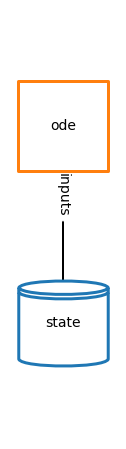

In [21]:
settings = {
    'buffer': 1.0,
}
tellurium_topology = plot_topology(ode_composite, settings)

### Run a simulation

In [10]:
total_time = 30.

# get initial state from composite
ode_initial_state = ode_composite.initial_state()
ode_initial_state = remove_multi_update(ode_initial_state)

# make an experiment
ode_experiment = Engine(
    processes=ode_composite.processes,
    topology=ode_composite.topology,
    initial_state=ode_initial_state,
)

# run the simulation
ode_experiment.update(total_time)


Simulation ID: 26bab340-295f-11ec-8397-8c85908ac627
Created: 10/09/2021 at 17:15:19
Completed in 0.084310 seconds


### Plot simulation output

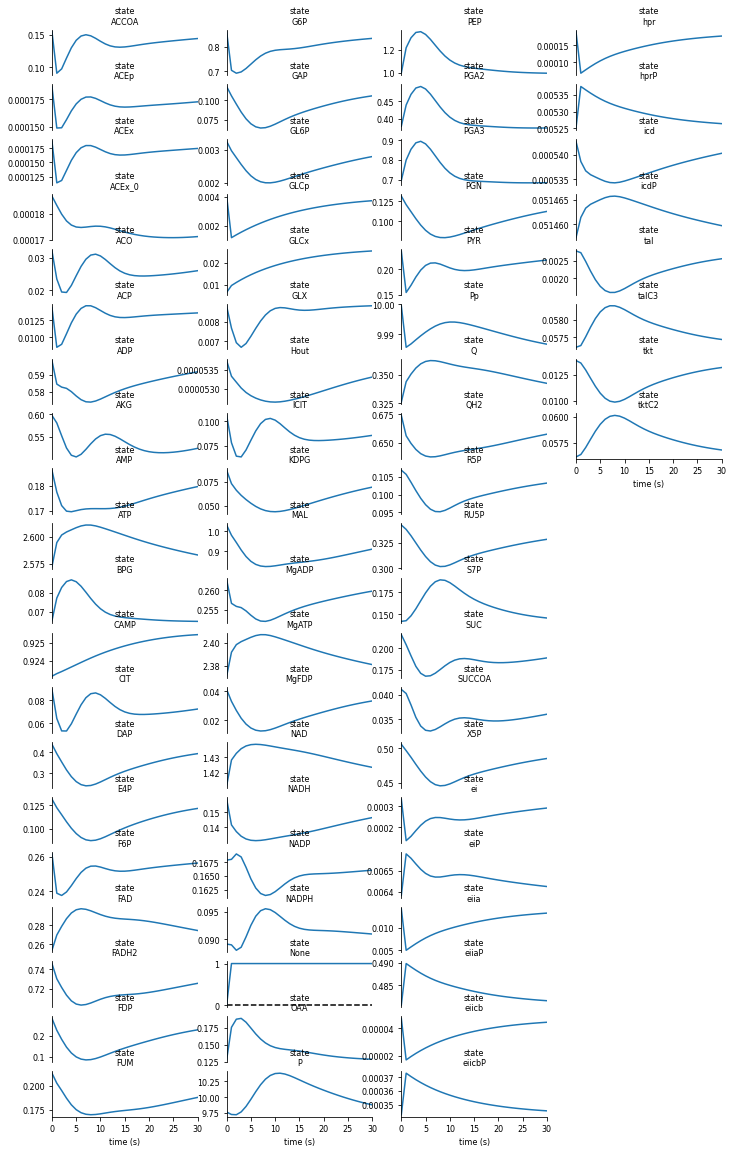

In [11]:
# get the data from the emitter
ode_output = ode_experiment.emitter.get_timeseries()

# plot
settings = {
    'max_rows': 20,
}
fig = plot_simulation_output(ode_output, settings)

## FBA process

### Generate a COBRApy BioSimulators process
This uses BiGG model [iAF1260b](http://bigg.ucsd.edu/models/iAF1260b)

In [6]:
# FBA config
fba_config = {
    'biosimulator_api': 'biosimulators_cobrapy',
    'model_source': BIGG_iAF1260b_PATH,
    'model_language': ModelLanguage.SBML.value,
    'simulation': 'steady_state',
    'algorithm': {
        'kisao_id': 'KISAO_0000437',
    }
}

# make the process
fba_process = BiosimulatorProcess(fba_config)

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


### Generate a COBRApy composite
Add a `Timeline` process that lets you change the flux bounds at different points in time

In [33]:
from vivarium.processes.timeline import TimelineProcess

total_fba_time = 10.

timeline = [
    (0, {
        ('state', 'lower_bound_reaction_R_EX_glc__D_e'): -10,
    }),
    (4, {
        ('state', 'lower_bound_reaction_R_EX_glc__D_e'): -0,
    }),
    (7, {
        ('state', 'upper_bound_reaction_R_EX_lac__D_e'): -10,
    }),
    (total_fba_time, {})
]

timeline_process = TimelineProcess({'timeline': timeline})

# make a composite
fba_composite = Composite({
    'processes': {
        'cobrapy': fba_process,
        'timeline': timeline_process,
    },
    'topology': {
        'cobrapy': {
            'outputs': ('state',),
            'inputs': ('state',),
        },
        'timeline': {
            'global': ('time',),
            'state': ('state',),
        },
    }
})

### Plot COBRA-Clock topology

In [34]:
settings = {}
fba_topology = plot_topology(fba_composite, settings)

### Run a simulation

In [35]:
# get initial state from composite
fba_initial_state = fba_composite.initial_state()
fba_initial_state = remove_multi_update(fba_initial_state)

# make an experiment
fba_experiment = Engine(
    processes=fba_composite.processes,
    topology=fba_composite.topology,
    initial_state=fba_initial_state,
)
# run the simulation
fba_experiment.update(total_fba_time)


Simulation ID: 331301f0-2a46-11ec-b51c-acde48001122
Created: 10/10/2021 at 20:49:13
Completed in 2.02 seconds


### Plot simulation output

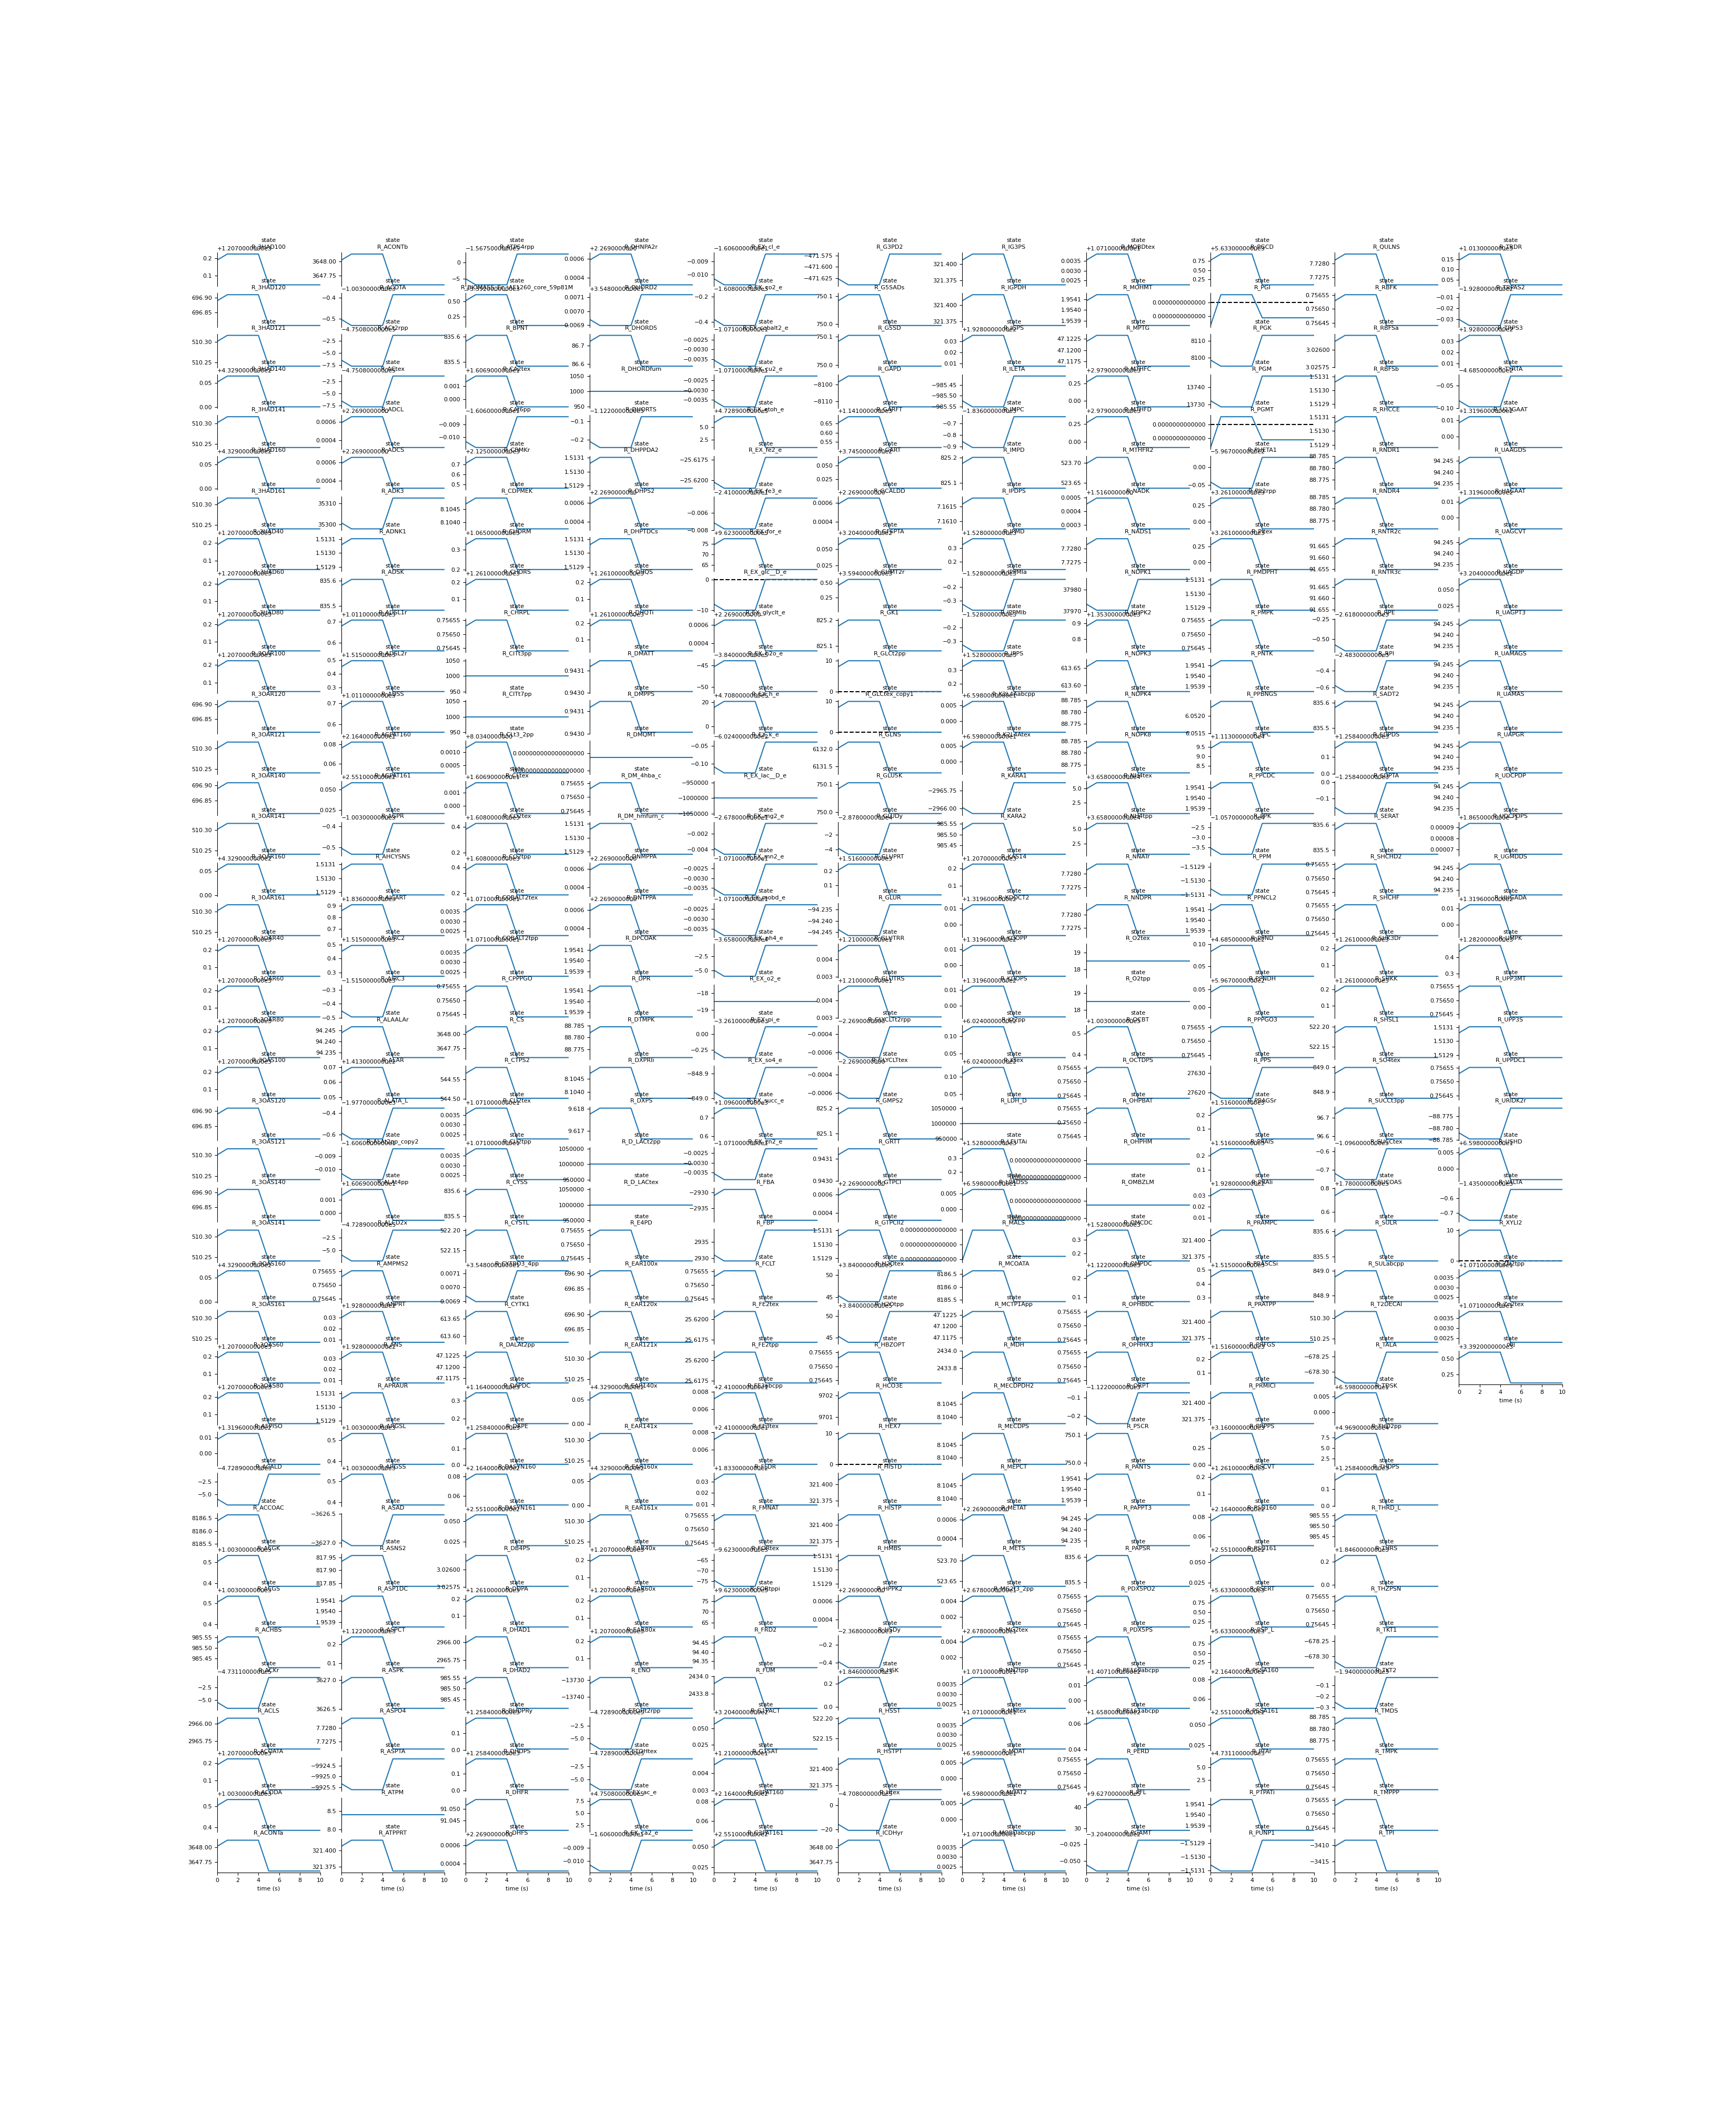

In [36]:
# get the data from emitter
fba_output = fba_experiment.emitter.get_timeseries()

settings = {'max_rows': 40}
fba_fig = plot_simulation_output(fba_output, settings)

## Flux Converter Process
The FluxBoundsConverter is a wrapper process that adds a 'flux_bounds' port to an ODE BioSimulator, which can plug into and FBA process' flux bounds inputs.

In [37]:
from vivarium_biosimulators.processes.flux_bounds import FluxBoundsConverter

FLUX_TO_BOUNDS_MAP = {
    'GLCp': 'upper_bound_reaction_R_EX_glc__D_e',
}

flux_ids = [rxn_id for rxn_id in FLUX_TO_BOUNDS_MAP.keys()]

# make an ode process
ode_config_2 = {
    'output_ports': {'fluxes': flux_ids},
    'emit_ports': ['outputs', 'fluxes'],
    **ode_config,
}
ode_process_2 = BiosimulatorProcess(ode_config_2)
        
# make the flux bounds converter process
flux_bounds_config = {
    'ode_process': ode_process_2,
    'flux_to_bound_map': FLUX_TO_BOUNDS_MAP,
    'flux_unit': 'mol/L',
    'bounds_unit': 'mmol/L/s',
}
ode_flux_converter = FluxBoundsConverter(flux_bounds_config)

RuntimeError: could not set value for MgADP, it is defined by an assignment rule, can not be set independently., at int rrllvm::LLVMExecutableModel::setValues(bool (*)(rrllvm::LLVMModelData *, int, double), GetNameFuncPtr, size_t, const int *, const double *)

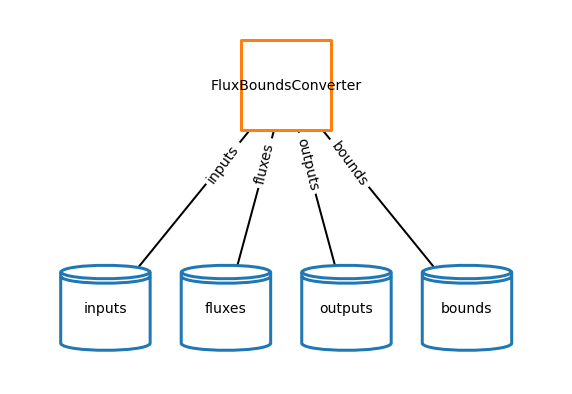

In [30]:
settings = {}
fba_topology = plot_topology(ode_flux_converter, settings)

## ODE_FBA Composite
ODE_FBA is a Vivarium Composer that is specifically designed to support a BioSimulator ODE and a BioSimulator FBA process in a hybrid simulation.

In [ ]:
from vivarium_biosimulators.composites.ode_fba import ODE_FBA

In [32]:
# ode_fba configuration
config = {
    'ode_config': {
        'biosimulator_api': 'biosimulators_tellurium',
        'model_source': SBML_MODEL_PATH,
        'simulation': 'uniform_time_course',
        'model_language': ModelLanguage.SBML.value,
        'algorithm': {
            'kisao_id': 'KISAO_0000019',
        }
    },
    'fba_config': {
        'biosimulator_api': 'biosimulators_cobrapy',
        'model_source': BIGG_MODEL_PATH,
        'simulation': 'steady_state',
        'model_language': ModelLanguage.SBML.value,
        'algorithm': {
            'kisao_id': 'KISAO_0000437',
        }
    },
    'flux_to_bound_map': FLUX_TO_BOUNDS_MAP,
    'flux_unit': 'mol/L',
    'bounds_unit': 'mmol/L/s',
    # 'bounds_unit': 'mmol/g/hr',
    'default_store_name': 'state',
}
ode_fba_composer = ODE_FBA(config)

In [35]:
# get initial state from composer
initial_state = ode_fba_composer.initial_state()
initial_state['bounds']['R_EX_glc__D_e_lower_bound'] = -2.0

# generate the composite
ode_fba_composite = ode_fba_composer.generate()

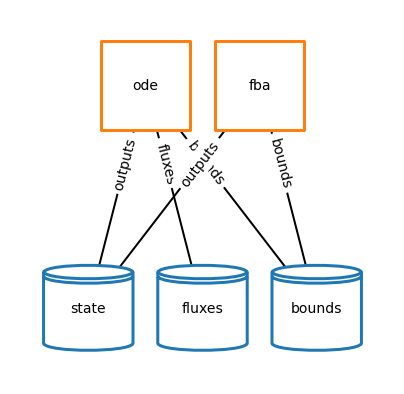

In [36]:
settings = {}
ode_fba_topology = plot_topology(ode_fba_composite, settings)